## 验证 [MMSSL](https://github.com/HKUDS/MMSSL) provided 数据集

In [10]:
!ls /nvme0n1p2/MMSSL/tiktok/

audio_feat.npy	test.json      train.json  val.json
image_feat.npy	text_feat.npy  train_mat


这是个 Pure JSON

In [16]:
!head /nvme0n1p2/MMSSL/tiktok/train.json

{"0": [885, 1387, 5424], "1": [490, 2674, 2678], "2": [1, 16, 27, 37, 40, 49, 57, 60, 88, 98, 105, 111, 118, 121, 122, 125, 149, 150, 153, 160, 172, 249, 280, 283, 319, 350, 353, 380, 386, 388, 391, 393, 406, 435, 436, 465, 469, 476, 480, 482, 491, 515, 528, 561, 565, 566, 570, 574, 575, 579, 640, 646, 649, 681, 682, 692, 706, 736, 750, 788, 789, 807, 812, 824, 857, 869, 874, 878, 884, 892, 939, 940, 958, 983, 1006, 1013, 1015, 1017, 1028, 1048, 1054, 1058, 1063, 1065, 1072, 1095, 1100, 1105, 1125, 1157, 1192, 1194, 1204, 1207, 1216, 1231, 1236, 1237, 1266, 1273, 1313, 1323, 1330, 1334, 1342, 1352, 1380, 1391, 1396, 1441, 1452, 1467, 1468, 1477, 1485, 1496, 1514, 1516, 1525, 1565, 1567, 1585, 1609, 1612, 1631, 1634, 1667, 1697, 1701, 1712, 1746, 1751, 1755, 1772, 1774, 1784, 1788, 1810, 1819, 1823, 1848, 1887, 1963, 2023, 2026, 2029, 2031, 2050, 2103, 2153, 2189, 2207, 2233, 2238, 2262, 2271, 2274, 2296, 2298, 2302, 2308, 2342, 2371, 2375, 2390, 2404, 2410, 2418, 2447, 2470, 2471, 2492

### npy

In [1]:
import numpy as np

In [2]:
tiktok_path = "/nvme0n1p2/MMSSL/tiktok"

In [3]:
image_feat = np.load(f"{tiktok_path}/image_feat.npy")
text_feat = np.load(f"{tiktok_path}/text_feat.npy")

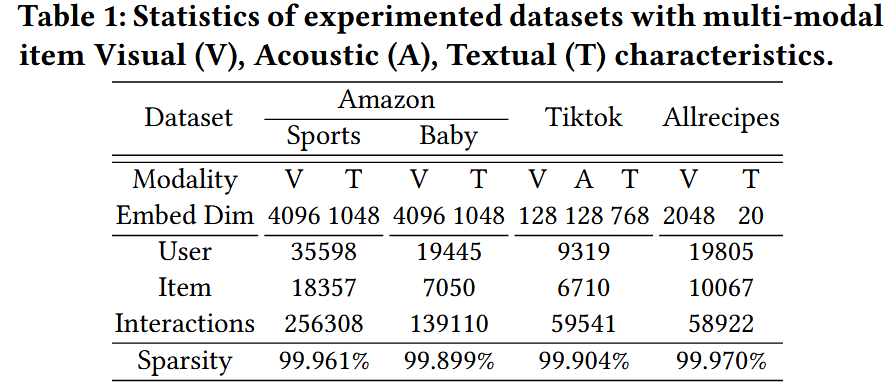

In [4]:
print(f"image: {image_feat.shape}, text: {text_feat.shape}")

image: (6710, 128), text: (6710, 768)


### json

In [58]:
import json
from dataclasses import dataclass

@dataclass
class Statistic:
    user_num: int = 0
    item_num: int = 0
    interactions: int = 0
    user_without_items: int = 0
    sparsity: float = 0.

    def __str__(self) -> str:
        format_str = f"user: {self.user_num}, item: {self.item_num}\n"
        format_str += f"interactions: {self.interactions}\n"
        format_str += f"sparsity: {self.sparsity*100:.3f}%"
        return format_str

def cal_dataset(path):
    statistic = Statistic()
    with open(path, 'r') as file:
        data: dict[str, list[str]] = json.load(file)
    
    statistic.user_num = len(data)
    item_set = set()

    for _, items in data.items():
        if len(items) == 0:
            statistic.user_without_items += 1
            continue
        statistic.interactions += len(items)
        for item in items: item_set.add(item)
    
    statistic.item_num = len(item_set)
    statistic.sparsity = 1 - (statistic.interactions/(statistic.user_num*statistic.item_num))

    return statistic

In [59]:
train = cal_dataset(f"{tiktok_path}/train.json")
value = cal_dataset(f"{tiktok_path}/val.json")
test = cal_dataset(f"{tiktok_path}/test.json")

In [60]:
print(train)

user: 9308, item: 6245
interactions: 59541
sparsity: 99.898%


In [61]:
print(value)

user: 3051, item: 1272
interactions: 3051
sparsity: 99.921%


In [62]:
print(test)

user: 9319, item: 1855
interactions: 6130
sparsity: 99.965%


这...

### mat

没有后缀，但看起来就是个`.mat`文件

In [14]:
import scipy.io

train_mat = scipy.io.loadmat(f"{tiktok_path}/train_mat")

ValueError: Unknown mat file type, version 99, 116

读不了，看来是较新版的 MATLAB 做的

In [13]:
import h5py

# 读取 .mat 文件
with h5py.File(f"{tiktok_path}/train_mat", 'r') as f:
    # 查看所有变量
    print(list(f.keys()))
    
    # 访问特定变量
    # my_variable = f['my_variable'][:]

OSError: Unable to open file (file signature not found)

阿哲..? 算了不重要, 重构吧

## 重构 MMSSL provided 数据集为常规三元组

In [15]:
!ls /nvme0n1p2/MMSSL/tiktok/

audio_feat.npy	test.json      train.json  train_mat.mat
image_feat.npy	text_feat.npy  train_mat   val.json


In [33]:
import json
import os

tiktok_path = "/nvme0n1p2/MMSSL/tiktok"

# 读取所有数据
with open(f"{tiktok_path}/train.json", 'r') as f1:
    train_data: dict[str, list[str]] = json.load(f1)
with open(f"{tiktok_path}/val.json", 'r') as f2:
    val_data: dict[str, list[str]] = json.load(f2)
with open(f"{tiktok_path}/test.json", 'r') as f3:
    test_data: dict[str, list[str]] = json.load(f3)


# 先全部合并到train_data
for val_user, val_items in val_data.items():
    train_user: list[str] = train_data.get(val_user, [])
    if len(train_user) == 0: # 验证集数据在训练集不存在
        train_data[val_user] = val_items  # 在训练集中新增
    else:
        # 在训练集中添加差异数据
        filter_items = [val_item for val_item in val_items if val_item not in train_user]
        train_data[val_user].extend(filter_items)

for test_user, test_items in test_data.items():
    train_user: list[str] = train_data.get(test_user, [])
    if len(train_user) == 0:
        train_data[test_user] = test_items
    else:
        filter_items = [i for i in test_items if i not in train_user]
        train_data[test_user].extend(filter_items)

print(f"After merge: {len(train_data)}")

After merge: 9319


In [36]:
none_user = 0
none_user_set = set()
for user, items in train_data.items():
    if len(items)==0:
        none_user+=1
        none_user_set.add(user)
print(f'{none_user} users have no items, occupy {none_user/len(train_data)*100:.2f}%')

11 users have no items, occupy 0.12%


11 个用户完全没有交互项目，那还留着干什么，纯纯的脏数据

In [37]:
os.makedirs('tiktok_out', exist_ok=True)
with open('tiktok_out/tiktok_merge.txt', 'w') as f:
    for user, items in train_data.items():
        if user in none_user_set: continue
        for item in items:
            # 该数据集未记录评分, ratings 全部置为1
            f.write(f"{user} {item} 1\n")
print('save done')

save done


In [41]:
%%bash
wc -l tiktok_out/tiktok_merge.txt

68722 tiktok_out/tiktok_merge.txt


## 校验数据集完整性

目测了一下，这个数据集没有做 10-core 处理。所以校验主要是看每个 item 对应的 image/text feat 是否存在

In [63]:
user_set = set()
item_set = set()
interactions = 0

with open('tiktok_out/tiktok_merge.txt', 'r') as file:
    for idx, line in enumerate(file):
        user = line.split(' ')[0]
        item = line.split(' ')[1]
        user_set.add(user)
        item_set.add(item)
        interactions = idx + 1

print(f"user: {len(user_set)}, item: {len(item_set)}, interactions: {interactions}")

user: 9308, item: 6710, interactions: 68722


这就对上了，9319个用户有11个空的，去掉后是9308；项目有6710个

交互数量估计是计算方式不同吧

In [65]:
import numpy as np
tiktok_path = "/nvme0n1p2/MMSSL/tiktok"
image_feat = np.load(f"{tiktok_path}/image_feat.npy")
text_feat = np.load(f"{tiktok_path}/text_feat.npy")

In [69]:
print(image_feat.shape)
print(text_feat.shape)

(6710, 128)
(6710, 768)


多模态数据都是对应6710个item的，所以检查数据集中item id是否在0-6709之间即可。

In [72]:
uids = []
iids = []
for user in user_set:
    uids.append(int(user))
for item in item_set:
    iids.append(int(item))
print(f"max user: {max(uids)}, max item: {max(iids)}")

max user: 9307, max item: 6709


划分数据集

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('tiktok_out/tiktok_merge.txt', delimiter=' ', header=None)

# 检查重复行
print(f"原始数据重复行数: {data.duplicated().sum()}")

# 划分训练集和测试集，比例为7:3
train_data, test_data = train_test_split(data, test_size=0.3, random_state=114514)

train_data.to_csv('tiktok_ds/train_data.txt', index=False, header=False, sep=' ')
test_data.to_csv('tiktok_ds/test_data.txt', index=False, header=False, sep=' ')

# 查看划分后的数据集大小
print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

# 检查是否有重复项
print(f"训练数据重复行数: {train_data.duplicated().sum()}")
print(f"测试数据重复行数: {test_data.duplicated().sum()}")
duplicates_in_train = train_data.merge(test_data, how='inner')
print(f'训练集和测试集中的重复行:\n{duplicates_in_train}')


原始数据重复行数: 0
训练集大小: 48105
测试集大小: 20617
训练数据重复行数: 0
测试数据重复行数: 0
训练集和测试集中的重复行:
Empty DataFrame
Columns: [0, 1, 2]
Index: []
